In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_csv('Fake_Real_Data.csv')

In [3]:
df.shape

(9900, 2)

In [4]:
df.head()

,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


In [5]:
df['label'].value_counts()

label
Fake    5000
Real    4900
Name: count, dtype: int64

In [6]:
df.duplicated().sum()

np.int64(35)

In [7]:
df.drop_duplicates(inplace=True)

In [8]:
df.isna().sum()

Text     0
label    0
dtype: int64

In [9]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ajayk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ajayk\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ajayk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\ajayk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [10]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

In [11]:
import re
def preprocess(text):
    text = re.sub(r"[^a-zA-Z]", " ", text)   # Remove non-alphabet chars
    tokens = nltk.word_tokenize(text.lower())  # Tokenize & lowercase
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(tokens)

In [12]:
df['clean_text'] = df['Text'].apply(preprocess)

In [13]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [14]:
X = df['clean_text']
y = df['label']

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [16]:
count_vec = CountVectorizer(stop_words='english', ngram_range=(1,2))  # unigrams + bigrams
X_train_count = count_vec.fit_transform(X_train)
X_test_count = count_vec.transform(X_test)

DecisionTreeClassifier()
100
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1481
           1       1.00      1.00      1.00      1479

    accuracy                           1.00      2960
   macro avg       1.00      1.00      1.00      2960
weighted avg       1.00      1.00      1.00      2960



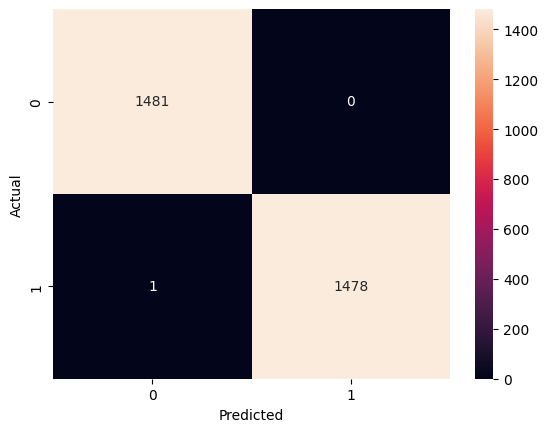

MultinomialNB()
98
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1481
           1       0.98      0.98      0.98      1479

    accuracy                           0.98      2960
   macro avg       0.98      0.98      0.98      2960
weighted avg       0.98      0.98      0.98      2960



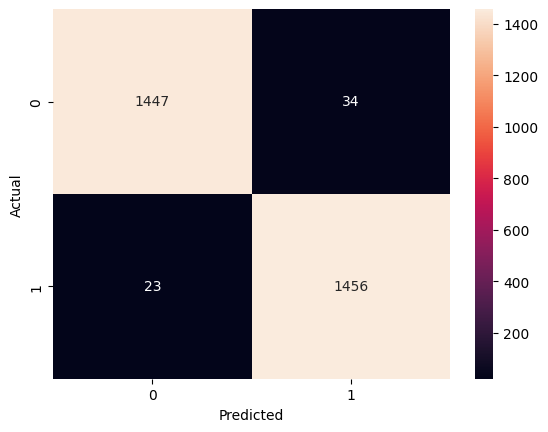

SVC()
99
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1481
           1       0.99      1.00      0.99      1479

    accuracy                           0.99      2960
   macro avg       0.99      0.99      0.99      2960
weighted avg       0.99      0.99      0.99      2960



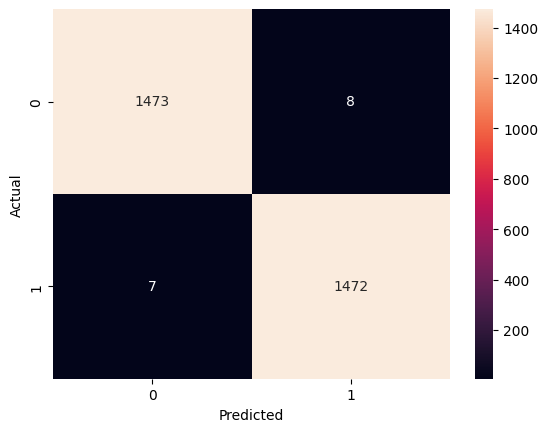

RandomForestClassifier()
100
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1481
           1       1.00      0.99      1.00      1479

    accuracy                           1.00      2960
   macro avg       1.00      1.00      1.00      2960
weighted avg       1.00      1.00      1.00      2960



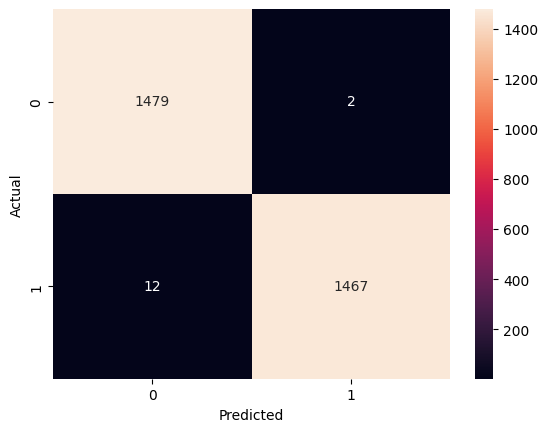

LogisticRegression()
100
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1481
           1       1.00      1.00      1.00      1479

    accuracy                           1.00      2960
   macro avg       1.00      1.00      1.00      2960
weighted avg       1.00      1.00      1.00      2960



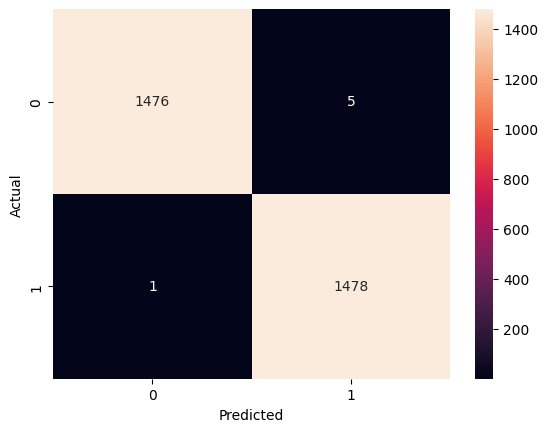

In [17]:
models={LogisticRegression(), SVC(), DecisionTreeClassifier(), MultinomialNB(), RandomForestClassifier()}
for model in models:
    model.fit(X_train_count, y_train)
    y_pred=model.predict(X_test_count)
    print(model)
    print(round(accuracy_score(y_test, y_pred)*100))
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [18]:
print((cross_val_score(LogisticRegression(), X_train_count, y_train,cv=5).mean())*100)

99.82621288921072


In [19]:
best_model = LogisticRegression()

In [20]:
import gradio as gr
import joblib

joblib.dump(best_model, "text_classifier.pkl")

# Load model for inference
model = joblib.load("text_classifier.pkl")

# Define prediction function
def predict(text):
    prediction = model.predict([text])[0]
    probability = model.predict_proba([text])[0].max()
    return f"Prediction: {prediction} (Confidence: {probability:.2f})"

# Create Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Textbox(lines=5, placeholder="Enter your text here..."),
    outputs="text",
    title="Text Classification with Logistic Regression",
    description="Enter a piece of text and the model will classify it."
)

# Launch the app
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


Traceback (most recent call last):
  File "C:\Users\ajayk\AppData\Roaming\Python\Python311\site-packages\gradio\queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ajayk\AppData\Roaming\Python\Python311\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ajayk\AppData\Roaming\Python\Python311\site-packages\gradio\blocks.py", line 2229, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ajayk\AppData\Roaming\Python\Python311\site-packages\gradio\blocks.py", line 1740, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ajayk\AppData\Roaming\Python\Python311\site-packages\anyio\to_thr